# Speech Phoneme Analysis and Classification
***
# Table of Contents
1.   [Introduction](#Introduction)
2.   [Imports](#Imports)
3.   [Data Processing and Visualisation](#Data-Processing-and-Visualisation)
4.   [Model Creation and Investigation](#Model-Creation-and-Investigation)

# Introduction

This notebook is the coding part of the assignment. I go over what I did and how in small notes. A detailed methodology
will be found in the report pdf.

# Imports

5 libraries are needed for this project:
* itertools - For confusion matrix plotting
* numpy - Efficient data arrays
* pandas - Loading data
* matplotlib - Visualisation
* sklearn - Provides functionality for model creation and investigation

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

# Data Processing and Visualisation

In this section I collect the data from the csv file, do some processing and visualize it. I collected this data so I
will be noting my expectations in a md cell above the code cells. Any observations I will make like interpreting a graph,
I will write in a md cell after code cell.

Here I read the csv file into ```dataset``` using the pandas library. This will give me a Dataframe object which I fin very
useful for ML and/or big data applications. Even though this dataset is not very big I can still utilize its features.

After reading in the data I shuffle it and print some statistics. The row count should be 150 and column count should
be 8.

By using ```dataset.head()``` I can confirm that the dataset is in fact shuffled.

In [2]:
dataset = pd.read_csv("Data Collection.csv")
dataset = shuffle(dataset)

rows = list(dataset.axes[0])
columns = list(dataset.axes[1])
print('Row Count: ', len(rows))
print('Column Count: ', len(columns))

dataset.head()

Row Count:  150
Column Count:  8


,Speaker,Gender,Word,Phoneme,Time,Formant1,Formant2,Formant3
117,dwc001,M,heed,IY,1.338715,282.335701,2444.476771,2787.374746
42,jmc001,F,heed,IY,2.394995,380.443252,2680.203593,3195.729489
104,jfj001,F,head,EH,3.570471,814.141188,2204.481587,3176.790012
73,jkb001,F,hid,IH,3.610283,415.041989,2711.290532,2912.498013
21,ars001,M,heed,IY,2.887479,115.574294,2129.421166,2869.839870


Now I check for any null values in the dataset. I expect no null values.

In [3]:
null_count = dataset.isnull().sum().sum()
print("Total Null values count: ", null_count)

dataset_size = len(rows)* len(columns)
print("Total values in dataframe: ", dataset_size)

print("Percentage of null values: ", (null_count / dataset_size) * 100)

Total Null values count:  0
Total values in dataframe:  1200
Percentage of null values:  0.0


Before proceeding continuing with processing the data, I visualize all the features except Speaker and Time since I will
not be using these features for my Knn model. For the pie charts I visualise the Word feature so that I prove that I did
not distinguish the actual phoneme while doing data collection but assigned each word a phoneme and collected data in that
manner.

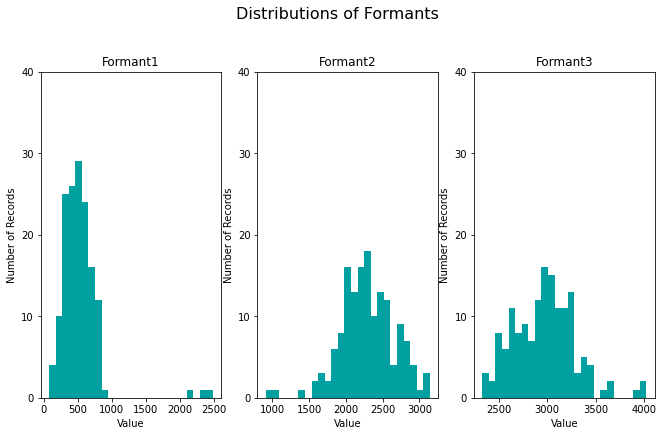

In [4]:
# Create figure
fig = plt.figure(figsize=(11, 6))
gs = gridspec.GridSpec(1, 3)
# Skewed feature plotting
for i, feature in enumerate(['Formant1', 'Formant2', 'Formant3']):
    ax = plt.subplot(gs[0, i])
    ax.hist(dataset[feature], bins=25, color='#00A0A0')
    ax.set_title(feature)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 40))
    ax.set_yticks([0, 10, 20, 30, 40])

# Plot aesthetics
fig.suptitle("Distributions of Formants", fontsize=16, y=1.03)
fig.savefig('Formant Histograms.png')

From these 3 histograms I can gather that Formants 2 and 3 are more distributed than Formant 1. I think this will affect
the predictive accuracy of the model because if Formants 2 and 3 where less distributed the distance between each node
would be smaller.

Now I plot the distribution of Gender, Word and Phoneme as pie charts. The Gender pie chart should be equally split,
while the other 2 should be split in 3 equal parts.

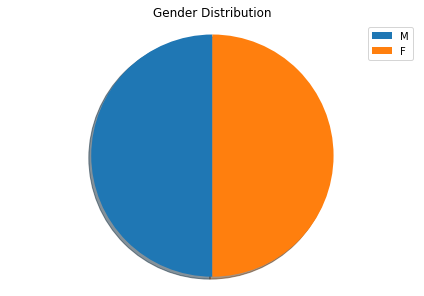

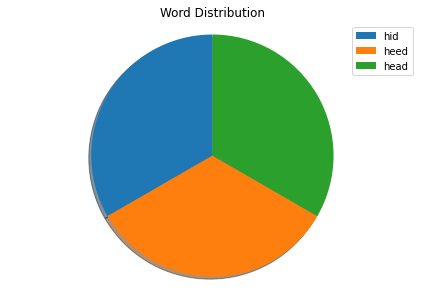

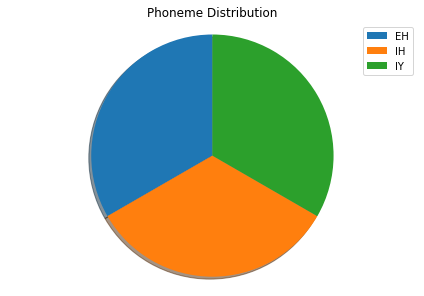

In [5]:
def PieFeatureDistribution(df:pd.DataFrame, feature:str):
    # Visualizing Activity Distribution
    temp = df[feature].value_counts()
    df = pd.DataFrame({'labels': temp.index,
                       'values': temp.values
                      })

    labels = df['labels']
    sizes = df['values']
    patches, texts = plt.pie(sizes, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.title(feature + " Distribution")
    plt.savefig(feature + ' Distribution.png')
    plt.show()

PieFeatureDistribution(dataset, "Gender")
PieFeatureDistribution(dataset, "Word")
PieFeatureDistribution(dataset, "Phoneme")

Here I define the encode values I will use for the categorical variables.

In [6]:
phoneme_encode =    {
                        "IY":0,
                        "IH":1,
                        "EH":2,
                    }

gender_encode = {
                    "F": 0,
                    "M": 1
                }

Now I encode the actual features.

In [7]:
dataset['Gender'] = dataset['Gender'].map(gender_encode)
dataset['Phoneme'] = dataset['Phoneme'].map(phoneme_encode)

Before splitting the dataset I first separate the Phoneme feature from the main dataset then I drop the Speaker, Time, Word
and Phoneme features from the dataset.

I separate Phoneme so that it can be used as the 'Y' part for model predictions, i.e. its the answer that the model
should predict.

In [8]:
phoneme = dataset['Phoneme']
dataset = pd.DataFrame(dataset.drop(['Speaker', 'Time', 'Phoneme', 'Word'],axis=1))

Lastly I split the dataset into 4 variables using train_test_split. The 'train' variables contain data from the Formant
features and Gender. While the 'test' variables have the train's corresponding phoneme value.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(dataset, phoneme, test_size=0.25, random_state=0)

# Model Creation and Investigation

In this section I initialise a KNN classifier and train it on the train dataset, then I get a number of metrics after on
predicting the test set after using gridsearch to identify the best parameters.

Initialise the KNN Classifier with default params, n_neighbors=5 and p=2.

In [10]:
clf = KNeighborsClassifier()

Define a number of different parameters and use gridsearch to identify the best parameters.

In [11]:
parameters =    {
                "n_neighbors": list(range(1,30,1)),
    # simply change p for 3 distance metrics
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric
                "p": [1, 2, 3],
                }

scorer = make_scorer(fbeta_score, beta=0.5,average='weighted')
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train)

print('The parameters combination that would give best accuracy is : ')
print(grid_fit.best_params_)

The parameters combination that would give best accuracy is : 
{'n_neighbors': 9, 'p': 1}


Set the best estimator to ```best_clf``` and fit the train set to ```clf```. ```best_clf``` already has its data fit
from the last step.

Then I get the predictions for both models.

In [12]:
# Set the best estimator
best_clf = grid_fit.best_estimator_
clf.fit(X_train, y_train)
# Make predictions using the unoptimized and optimized models
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test)

Print the accuracy, fbeta, precision and recall scores for both models

In [13]:
print("Unoptimized model\n------")
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5,average='weighted')))
print("Precision score on the testing data: {:.4f}".format(precision_score(y_test, predictions, average='weighted')))
print("Recall score on the testing data: {:.4f}".format(recall_score(y_test, predictions, average='weighted')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions, average='weighted')))

Unoptimized model
------
Accuracy score on the testing data: 0.8421
F-score on the testing data: 0.8375
Precision score on the testing data: 0.8475
Recall score on the testing data: 0.8421

Optimized Model
------
Final accuracy score on the testing data: 0.8158
Final F-score on the testing data: 0.8089
Final precision score on the testing data: 0.8125
Final recall score on the testing data: 0.8158


Here I change the plot_confusion_matrix from sklearn a little bit and then output it for the optimized model's predictions.

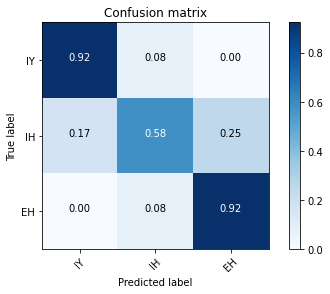

In [14]:
# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=phoneme_encode, normalize=True,title='Confusion matrix')
plt.savefig('Model Confusion Matrix Full Dataset.png')


The following steps are repetitions from above where I only use the Female data rows.

In [15]:
dataset['Phoneme'] = phoneme
dataset = dataset[dataset['Gender'] == 0]
phoneme = dataset['Phoneme']
dataset = pd.DataFrame(dataset.drop(['Phoneme'],axis=1))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dataset, phoneme, test_size=0.25, random_state=0)

In [17]:
clf = KNeighborsClassifier()

scorer = make_scorer(fbeta_score, beta=0.5,average='weighted')
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train)

print('The parameters combination that would give best accuracy is : ')
print(grid_fit.best_params_)
print()
# Get the estimator
best_clf = grid_fit.best_estimator_
clf.fit(X_train, y_train)
# Make predictions using the unoptimized and model
predictions = clf.predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5,average='weighted')))
print("Precision score on the testing data: {:.4f}".format(precision_score(y_test, predictions, average='weighted')))
print("Recall score on the testing data: {:.4f}".format(recall_score(y_test, predictions, average='weighted')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions, average='weighted')))

The parameters combination that would give best accuracy is : 
{'n_neighbors': 22, 'p': 3}

Unoptimized model
------
Accuracy score on the testing data: 0.7368
F-score on the testing data: 0.7437
Precision score on the testing data: 0.7478
Recall score on the testing data: 0.7368

Optimized Model
------
Final accuracy score on the testing data: 0.7368
Final F-score on the testing data: 0.7673
Final precision score on the testing data: 0.8238
Final recall score on the testing data: 0.7368


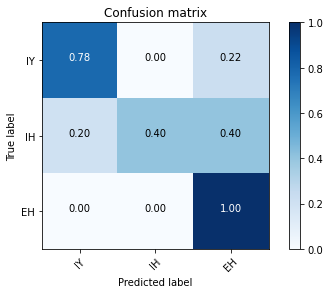

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=phoneme_encode, normalize=True,title='Confusion matrix')
plt.savefig('Model Confusion Matrix Female Dataset.png')